## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import shutil
import time

from fastai.transforms import *
from fastai.dataset import *
from fastai.fp16 import *
from fastai.conv_learner import *
from pathlib import *

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
import models.cifar10 as cifar10models
from distributed import DistributedDataParallel as DDP

# print(models.cifar10.__dict__)
model_names = sorted(name for name in models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(models.__dict__[name]))

cifar10_names = sorted(name for name in cifar10models.__dict__
                     if name.islower() and not name.startswith("__")
                     and callable(cifar10models.__dict__[name]))

model_names = cifar10_names + model_names

In [3]:

# print(model_names)

# Example usage: python run_fastai.py /home/paperspace/ILSVRC/Data/CLS-LOC/ -a resnext_50_32x4d --epochs 1 -j 4 -b 64 --fp16

parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--save-dir', type=str, default=Path.home()/'imagenet_training',
                    help='Directory to save logs and models.')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet56',
                    choices=model_names,
                    help='model architecture: ' +
                    ' | '.join(model_names) +
                    ' (default: resnet56)')
parser.add_argument('-j', '--workers', default=7, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=1, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--cycle-len', default=95, type=float, metavar='N',
                    help='Length of cycle to run')
# parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
#                     help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=512, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.8, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
# parser.add_argument('--print-freq', '-p', default=10, type=int,
#                     metavar='N', help='print frequency (default: 10)')
# parser.add_argument('--resume', default='', type=str, metavar='PATH',
#                     help='path to latest checkpoint (default: none)')
# parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
#                     help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
parser.add_argument('--fp16', action='store_true', help='Run model fp16 mode.')
parser.add_argument('--use-tta', default=True, type=bool, help='Validate model with TTA at the end of traiing.')
parser.add_argument('--train-half', action='store_true', help='Train model on half images. TODO: allow custom epochs and LR')
parser.add_argument('--sz',       default=32, type=int, help='Size of transformed image.')
# parser.add_argument('--decay-int', default=30, type=int, help='Decay LR by 10 every decay-int epochs')
parser.add_argument('--use-clr', default='10,13.68,0.95,0.85', type=str, 
                    help='div,pct,max_mom,min_mom. Pass in a string delimited by commas. Ex: "20,2,0.95,0.85"')
parser.add_argument('--loss-scale', type=float, default=128,
                    help='Loss scaling, positive power of 2 values can improve fp16 convergence.')
parser.add_argument('--prof', dest='prof', action='store_true', help='Only run a few iters for profiling.')

parser.add_argument('--dist-url', default='file://sync.file', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')

parser.add_argument('--world-size', default=1, type=int,
                    help='Number of GPUs to use. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')
parser.add_argument('--rank', default=0, type=int,
                    help='Used for multi-process training. Can either be manually set ' +
                    'or automatically set by using \'python -m multiproc\'.')

class TorchModelData(ModelData):
    def __init__(self, path, trn_dl, val_dl, aug_dl=None):
        super().__init__(path, trn_dl, val_dl)
        self.aug_dl = aug_dl

def torch_loader(data_path, size):
    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])

    train_tfms = transforms.Compose([
    #   transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset)
                     if args.distributed else None)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_tfms = transforms.Compose([
    #   transforms.Resize(int(size*1.14)),
    #   transforms.CenterCrop(size),
        transforms.ToTensor(),
        normalize,
    ])
    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, val_tfms),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)


    aug_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    aug_loader = DataPrefetcher(aug_loader)
    if args.prof:
        train_loader.stop_after = 200
        val_loader.stop_after = 0

    data = TorchModelData(data_path, train_loader, val_loader, aug_loader)
    return data, train_sampler


# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break
                
def top5(output, target):
    """Computes the precision@k for the specified values of k"""
    top5 = 5
    batch_size = target.size(0)
    _, pred = output.topk(top5, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    correct_k = correct[:top5].view(-1).float().sum(0, keepdim=True)
    return correct_k.mul_(1.0 / batch_size)


class ImagenetLoggingCallback(Callback):
    def __init__(self, save_path, print_every=50):
        super().__init__()
        self.save_path=save_path
        self.print_every=print_every
    def on_train_begin(self):
        self.batch = 0
        self.epoch = 0
        self.f = open(self.save_path, "a", 1)
        self.log("\ton_train_begin")
    def on_epoch_end(self, metrics):
        log_str = f'\tEpoch:{self.epoch}\ttrn_loss:{self.last_loss}'
        for (k,v) in zip(['val_loss', 'acc', 'top5', ''], metrics): log_str += f'\t{k}:{v}'
        self.log(log_str)
        self.epoch += 1
    def on_batch_end(self, metrics):
        self.last_loss = metrics
        self.batch += 1
        if self.batch % self.print_every == 0:
            self.log(f'Epoch: {self.epoch} Batch: {self.batch} Metrics: {metrics}')
    def on_train_end(self):
        self.log("\ton_train_end")
        self.f.close()
    def log(self, string):
        self.f.write(time.strftime("%Y-%m-%dT%H:%M:%S")+"\t"+string+"\n")

# Logging + saving models
def save_args(name, save_dir):
    if (args.rank != 0) or not args.save_dir: return {}

    log_dir = f'{save_dir}/training_logs'
    os.makedirs(log_dir, exist_ok=True)
    return {
        'best_save_name': f'{name}_best_model',
        'cycle_save_name': f'{name}',
        'callbacks': [
            ImagenetLoggingCallback(f'{log_dir}/{name}_log.txt')
        ]
    }

def save_sched(sched, save_dir):
    if (args.rank != 0) or not args.save_dir: return {}
    log_dir = f'{save_dir}/training_logs'
    sched.save_path = log_dir
    sched.plot_loss()
    sched.plot_lr()

def update_model_dir(learner, base_dir):
    learner.tmp_path = f'{base_dir}/tmp'
    os.makedirs(learner.tmp_path, exist_ok=True)
    learner.models_path = f'{base_dir}/models'
    os.makedirs(learner.models_path, exist_ok=True)
    

### Resnet block

In [26]:
args_input = [
    '/home/paperspace/imagenet-fast/fp16/data/cifar10', 
    '--save-dir', '/home/paperspace/data/cifar_training/test1', 
#     '-a', 'resnet56', 
#     '-j', '6', 
#     '--prof', 
#     '-b', '512', 
#     '--sz', '32',
#     '--loss-scale', '128',
    '--fp16',
#     '--cycle-len', '95',
#     '--epochs', '1',
#     '--use-clr', '10,13.68,0.95,0.85',
    '--wd', '2e-4',
    '--lr', '1',
#     '--train-half' # With fp16, iterations are so fast this doesn't matter
]

In [27]:

# This is important for speed
cudnn.benchmark = True
global arg
args = parser.parse_args(args_input); args
if args.cycle_len > 1: args.cycle_len = int(args.cycle_len)

In [30]:
args.distributed = args.world_size > 1
args.gpu = 0
if args.distributed:
    args.gpu = args.rank % torch.cuda.device_count()

if args.distributed:
    torch.cuda.set_device(args.gpu)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                            world_size=args.world_size)

if args.fp16:
    assert torch.backends.cudnn.enabled, "fp16 mode requires cudnn backend to be enabled."

In [31]:
# create model
model = cifar10models.__dict__[args.arch] if args.arch in cifar10_names else models.__dict__[args.arch] 
if args.pretrained:
    print("=> using pre-trained model '{}'".format(args.arch))
    model = model(pretrained=True)
else:
    print("=> creating model '{}'".format(args.arch))
    model = model()

=> creating model 'resnet56'


In [32]:
model = model.cuda()
if args.distributed:
    model = DDP(model)

In [33]:
if args.train_half:
    data, train_sampler = torch_loader(args.data, 16)
else:
    data, train_sampler = torch_loader(args.data, args.sz)

learner = Learner.from_model_data(model, data)
# learner.crit = F.nll_loss
learner.crit = F.cross_entropy
learner.metrics = [accuracy]
if args.fp16: learner.half()

if args.prof:
    args.epochs = 1
    args.cycle_len=.01
if args.use_clr:
    args.use_clr = tuple(map(float, args.use_clr.split(',')))

In [34]:
# %pdb off

In [35]:
# 128x128
if args.train_half: 
    save_dir = args.save_dir+'/128'
    update_model_dir(learner, save_dir)
    sargs = save_args('first_run_128', save_dir)
    learner.fit(args.lr,args.epochs, cycle_len=45,
                train_sampler=train_sampler,
                wds=args.weight_decay,
                use_clr_beta=args.use_clr,
                loss_scale=args.loss_scale,
                **sargs
            )
    save_sched(learner.sched, save_dir)
    data, train_sampler = torch(args.data, args.sz)
    learner.set_data(data)

 37%|███▋      | 36/98 [00:03<00:05, 11.71it/s, loss=2.04]

Exception in thread Thread-290:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.708158   2.147934   0.2856    
    1      1.372696   1.34038    0.5218                   
    2      1.108697   1.113848   0.6036                   
    3      0.937529   1.004858   0.6424                    
    4      0.789451   0.795577   0.7214                    
    5      0.698764   0.876728   0.6928                    
    6      0.625548   0.827396   0.7091                    
    7      0.576596   0.73838    0.7474                    
    8      0.548972   0.779559   0.7344                    
    9      0.509791   0.749998   0.7422                    
    10     0.482989   0.875966   0.7164                    
    11     0.469541   1.049391   0.6909                    
    12     0.455231   0.770741   0.741                     
    13     0.436706   0.782277   0.7528                    
    14     0.418406   0.990503   0.6947                    
    15     0.42294    0.778554   0.7402                    

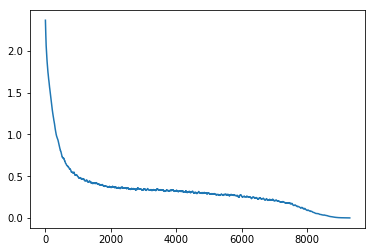

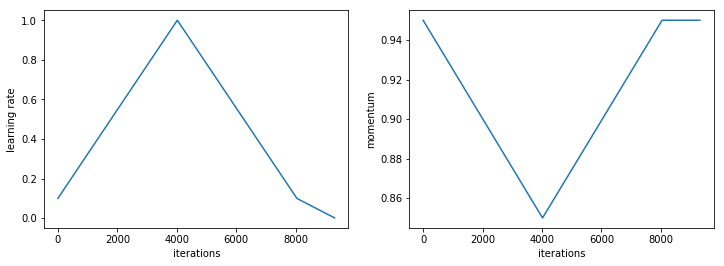

In [36]:
# Full size
update_model_dir(learner, args.save_dir)
sargs = save_args('first_run', args.save_dir)
learner.fit(args.lr,args.epochs, cycle_len=args.cycle_len,
            sampler=train_sampler,
            wds=args.weight_decay,
            use_clr_beta=args.use_clr,
            loss_scale=args.loss_scale,
            **sargs
           )
save_sched(learner.sched, args.save_dir)

print('Finished!')

In [38]:

if args.use_tta:
    log_preds,y = learner.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)
    
    with open(args.save_dir+'/tta_accuracy.txt', "a", 1) as f:
        f.write(time.strftime("%Y-%m-%dT%H:%M:%S")+f"\tTTA accuracty: {acc}\n")

TTA acc: 0.9226                              
